In [1]:
import BioSimSpace as BSS

INFO:rdkit:Enabling RDKit 2023.03.3 jupyter extensions


In [16]:
#loading 19-protein complex
files = ["input_files/amber.rst7", "input_files/amber.prm7"]
amber = BSS.IO.readMolecules(files)

In [18]:
#view 1
view = BSS.Notebook.View(amber)
view.system()

NGLWidget(gui_style='ngl')

In [22]:
#solvation with tip3p water

%env CUDA_VISIBLE_DEVICES=1

# Find the dimensions of the protein
box_min, box_max = amber.getAxisAlignedBoundingBox()

# Work out the box size from the difference in the coordinates.
box_size = [y - x for x, y in zip(box_min, box_max)]

# how much to pad each side of the protein (nonbonded cutoff = 10 A)
padding = 15 * BSS.Units.Length.angstrom

box_length = max(box_size) + 2 * padding

#cmplx = ff14_protein + comp_19_esp

solvated = BSS.Solvent.tip3p(molecule=amber, box=3 * [box_length])

env: CUDA_VISIBLE_DEVICES=1


In [23]:
#viewing the slvated system
view = BSS.Notebook.View(solvated)
view.system()

NGLWidget(gui_style='ngl')

In [24]:
#minimisation
%env CUDA_VISIBLE_DEVICES=1

protocol = BSS.Protocol.Minimisation(steps=5000)
process= BSS.Process.Amber(solvated, protocol,  exe='/usr/local/amber22_test/bin/pmemd.cuda')
process.start()
print(process.getTotalEnergy(block=True))

env: CUDA_VISIBLE_DEVICES=1
-3.3003e+05 kcal/mol


In [25]:
minimised = process.getSystem(block=True)

In [26]:
#equilibration

%env CUDA_VISIBLE_DEVICES=1

protocol= BSS.Protocol.Equilibration(runtime = 0.2 * BSS.Units.Time.nanosecond)
process = BSS.Process.Amber(minimised, protocol, exe='/usr/local/amber22_test/bin/pmemd.cuda', work_dir='equib_amber')
process
process.start()
equilibrated = process.getSystem(block=True)

env: CUDA_VISIBLE_DEVICES=1


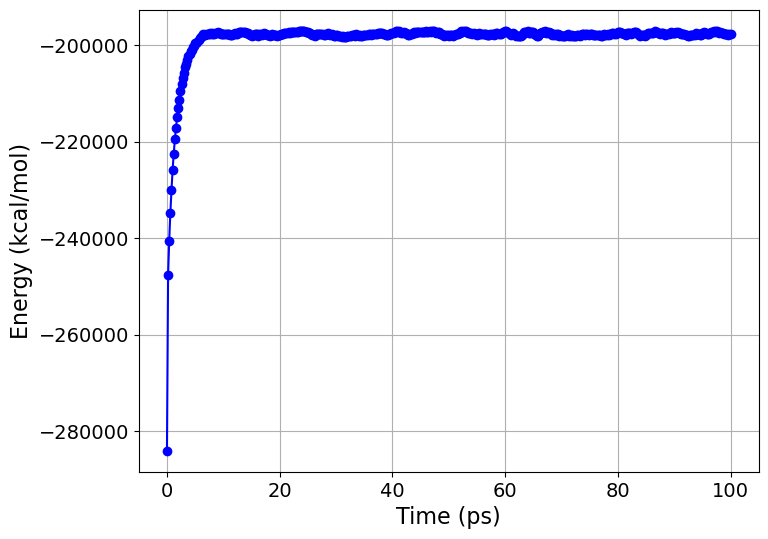

In [27]:
plot = BSS.Notebook.plot(process.getTime(time_series=True), process.getTotalEnergy(time_series=True))

In [28]:
#collecting the data for 1000 ns (note:report interval 125000 for the long simulations to get 4000 frames also, insead of 12500)
protocol = BSS.Protocol.Production(timestep=2.0000 * BSS.Units.Time.femtosecond, runtime= 1000 * BSS.Units.Time.nanosecond, report_interval = 5000, restart_interval=125000)
process = BSS.Process.Amber(equilibrated, protocol, exe='/usr/local/amber22_test/bin/pmemd.cuda', work_dir='prod_1000ns_amber_4000_3')
#process.start()

In [ ]:
#use set-up files by BSS to run slurm script for data production